#### Import Libraries

In [5]:
#pip install surprise

In [6]:
#pip install --upgrade pip setuptools wheel

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_tts
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

##### 1. Load Dataset

In [ ]:
# Load earlier cleaned and preprocessed data
df = pd.read_csv('netflix_cleaned_data.csv')

In [ ]:
# Check top rows
df.head()

,userId,movieId,rating,hour,weekday,(no genres listed),Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_avg,user_count,movie_avg
0,1,1,4.0,0.782609,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.8299,0.079164,0.760207,0.652439
1,1,3,4.0,0.782609,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.8299,0.079164,0.613248,0.155488
2,1,6,4.0,0.782609,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.8299,0.079164,0.765795,0.307927
3,1,47,5.0,0.826087,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.8299,0.079164,0.772304,0.615854
4,1,50,5.0,0.782609,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.8299,0.079164,0.830610,0.618902


In [10]:
# check distinct users and movies
print("Num users:", df['userId'].nunique(), "Num movies:", df['movieId'].nunique())

Num users: 610 Num movies: 9724


##### 2. Identify Feature Columns and Split Data

In [ ]:
# Separate colum features to use for training
feature_cols = [c for c in df.columns if c not in ['userId', 'movieId', 'rating']]

# Random Split of dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Add the feature columns and identifies ''ratings' as Target Column
X_train, y_train = train_df[feature_cols], train_df['rating']
X_test, y_test = test_df[feature_cols], test_df['rating']

##### 3. Model Building

##### 3.1 Baseline Predictive Model – Linear Regression

Rationale
* To learns a linear mapping between the engineered numeric features and the target variable
* Each model output represents a weighted sum of features plus an intercept
* Model is fitted to minimize prediction error (MSE) on the training set
* Prediction is on learned weights providing a benchmark to compare complex models

In [14]:
# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on Test data
pred_lr = lr.predict(X_test)

# Evaluate Performance
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}")

Linear Regression RMSE: 0.8113, MAE: 0.6167


Observations:
* On average, predicted ratings deviated from true ratings by about 0.81 stars on a 1–5 scale
* For instance if actual rating is 4, predicted rating is (4 - 0.81)
* Globally a deviation of 0.86 is tolerable for recommender engines
* 0.81 is therefore acceptable
* While for Mean Absolute Error, predictions are off by 0.67 stars
* To reduce the error and improve accuracy, we will adoped an advanced model i.e. SVD

##### 3.2 Collaborative Filtering Model – SVD (Surprise)

Rationale
* SVD factorizes the user–item interaction matrix into lower-dimensional latent factors
* It uncovers patterns and preferences that explicit features can’t capture alone 
* The model is able to predict unseen ratings based on hidden similarities
* Low computation requirement

In [15]:
# SVD Model Training
reader = Reader(rating_scale=(1,5)) # define scale
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader) # restricts data to userid, movieid and rating
trainset, testset = surprise_tts(data, test_size=0.2, random_state=42) # splits data

# Iniialize SVD Model
svd = SVD(n_factors=50, n_epochs=20, random_state=42)

# SVD Training
svd.fit(trainset)

# SVD Prediction
predictions = svd.test(testset)

In [16]:
# Restrict SVD Model Prediction prediction
pred_ratings = np.array([pred.est for pred in predictions])
true_ratings = np.array([pred.r_ui for pred in predictions])

# Evaluate Performance
rmse_svd = mean_squared_error(true_ratings, pred_ratings, squared=False)
mae_svd = mean_absolute_error(true_ratings, pred_ratings)
print(f"SVD RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

SVD RMSE: 0.8775, MAE: 0.6742


Observations
* Reduced performance when compared with Linear Regression results
* This indicates additional features like genre, movie and user stats used in linear regression provided more context
* 0.8775 is within tolerable range for SVD on small datasets which usually ranges from 0.85 to 0.95


##### Evaluate SVD Model Precision and Recall

* `Benchmark`: For MovieLens datasets which is considerable small in size, top 10 Precision should be ≥ 0.50 and top 10 Recall should be ≥ 0.60

In [17]:
# Evaluate SVD Ranking Metrics with Precision@K and Recall@K
def get_top_n(preds, n=10):
    top = defaultdict(list)
    for uid, iid, true_r, est, _ in preds:
        top[uid].append((iid, est))
    top_n = {uid: [iid for iid, _ in sorted(items, key=lambda x: x[1], reverse=True)[:n]] for uid, items in top.items()}
    return top_n

def precision_recall_at_k(preds, k=10, threshold=4.0):
    top_n = get_top_n(preds, n=k)
    actual = defaultdict(set)
    for uid, iid, true_r, est, _ in preds:
        if true_r >= threshold:
            actual[uid].add(iid)
    precisions, recalls = [], []
    for uid, pred_iids in top_n.items():
        act_iids = actual.get(uid, set())
        if act_iids:
            precisions.append(len(set(pred_iids) & act_iids) / k)
            recalls.append(len(set(pred_iids) & act_iids) / len(act_iids))
    return np.mean(precisions), np.mean(recalls)

prec_svd, recall_svd = precision_recall_at_k([(p.uid, p.iid, p.r_ui, p.est, None) for p in predictions])
print(f"SVD Precision@10: {prec_svd:.4f}, Recall@10: {recall_svd:.4f}")

SVD Precision@10: 0.5721, Recall@10: 0.6783


Observation:
*  5.7 out of the top 10 recommended movies are relevant with a a true rating ≥ 4
* The model captures 67.8% of all relevant movies for each user within its top 10 recommendations.
* Both recall and precision are above set benchmark and are therefore effective in the recommender system

##### 4. Model Evaluation Summary (Linear Regression and SVD)

In [18]:
# Summary Results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'SVD Collaborative Filter'],
    'RMSE': [rmse_lr, rmse_svd],
    'MAE': [mae_lr, mae_svd],
    'Precision@10': [None, prec_svd],
    'Recall@10': [None, recall_svd]
})
print(results)

                      Model      RMSE       MAE  Precision@10  Recall@10
0         Linear Regression  0.811331  0.616727           NaN        NaN
1  SVD Collaborative Filter  0.877468  0.674175      0.572101   0.678277


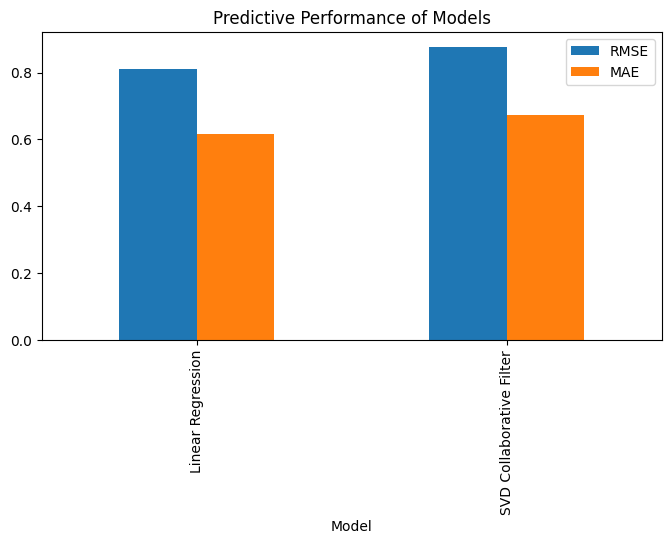

In [19]:
# Visual Comparison
results.set_index('Model')[['RMSE', 'MAE']].plot(kind='bar', figsize=(8,4))
plt.title('Predictive Performance of Models')
plt.show()

##### 5. Saving Trained Model

In [20]:
# Save trained models in Pickle files
pickle.dump(lr, open('lr_model.pkl', 'wb'))
pickle.dump(svd, open('svd_model.pkl', 'wb'))

## Model Improvement

##### Step 1: Integrate a new dataset 

In [21]:
# Load tag dataset
tags = pd.read_csv('tags.csv') 

# Clean tag dataset
tags['tag_clean'] = tags['tag'].str.lower().str.replace(r'[^a-z0-9]', '', regex=True)

# Tag Feature Engineering
tag_counts = tags.groupby(['movieId','tag_clean']).size().unstack(fill_value=0)
top_tags = tag_counts.sum().sort_values(ascending=False).head(50).index
tag_features = tag_counts[top_tags].reset_index()

In [22]:
# merge cleaned tag data into the cleaned datatset
df = df.merge(tag_features, on='movieId', how='left').fillna(0)

In [23]:
df.head()

,userId,movieId,rating,hour,weekday,(no genres listed),Action,Adventure,Animation,Children,...,classic,christmas,imdbtop250,psychological,comicbook,adolescence,ghosts,adultery,animation,boxing
0,1,1,4.0,0.782609,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4.0,0.782609,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,4.0,0.782609,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,47,5.0,0.826087,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50,5.0,0.782609,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Step 2: Re-process Consolidated Data

In [26]:
# Define numeric feature
numeric_cols = df.select_dtypes(include=[float, int]).columns.drop(
    ['userId', 'movieId', 'rating']
)

# Normalize
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Prune low-variance features
sel = VarianceThreshold(threshold=0.001)
X_scaled = sel.fit_transform(df[numeric_cols])
selected = numeric_cols[sel.get_support()]

In [27]:
# Concat scaled data with userid, movieid and rating
df = pd.concat([df[['userId','movieId','rating']],
                pd.DataFrame(X_scaled, columns=selected, index=df.index)],
               axis=1)

In [28]:
df.head()

,userId,movieId,rating,hour,weekday,(no genres listed),Action,Adventure,Animation,Children,...,classic,christmas,imdbtop250,psychological,comicbook,adolescence,ghosts,adultery,animation,boxing
0,1,1,4.0,0.782609,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4.0,0.782609,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,4.0,0.782609,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,47,5.0,0.826087,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50,5.0,0.782609,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Step 3: Retrain Baseline Model - Linear Regression

In [29]:
# Separate colum features to use for training
feature_cols = [c for c in df.columns if c not in ['userId', 'movieId', 'rating']]

# Random Split of dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Add the feature columns and identifies ''ratings' as Target Column
X_train, y_train = train_df[feature_cols], train_df['rating']
X_test, y_test = test_df[feature_cols], test_df['rating']

In [30]:
# Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on Test data
pred_lr = lr.predict(X_test)

# Evaluate Performance
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}")

Linear Regression RMSE: 0.8117, MAE: 0.6169


#### Step 4: Rebuild Collaborative Filtering Model - SVD

In [32]:
# SVD Model Training
reader = Reader(rating_scale=(1,5)) # define scale
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader) # restricts data to userid, movieid and rating
trainset, testset = surprise_tts(data, test_size=0.2, random_state=42) # splits data

# Iniialize SVD Model
svd = SVD(n_factors=50, n_epochs=20, random_state=42)

# SVD Training
svd.fit(trainset)

# SVD Prediction
predictions = svd.test(testset)

In [33]:
# Restrict SVD Model Prediction prediction
pred_ratings = np.array([pred.est for pred in predictions])
true_ratings = np.array([pred.r_ui for pred in predictions])

# Evaluate Performance
rmse_svd = mean_squared_error(true_ratings, pred_ratings, squared=False)
mae_svd = mean_absolute_error(true_ratings, pred_ratings)
print(f"SVD RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

SVD RMSE: 0.8775, MAE: 0.6742


In [39]:
# Evaluate SVD Ranking Metrics with Precision@K and Recall@K
def get_top_n(preds, n=20):
    top = defaultdict(list)
    for uid, iid, true_r, est, _ in preds:
        top[uid].append((iid, est))
    top_n = {uid: [iid for iid, _ in sorted(items, key=lambda x: x[1], reverse=True)[:n]] for uid, items in top.items()}
    return top_n

def precision_recall_at_k(preds, k=20, threshold=2.5):
    top_n = get_top_n(preds, n=k)
    actual = defaultdict(set)
    for uid, iid, true_r, est, _ in preds:
        if true_r >= threshold:
            actual[uid].add(iid)
    precisions, recalls = [], []
    for uid, pred_iids in top_n.items():
        act_iids = actual.get(uid, set())
        if act_iids:
            precisions.append(len(set(pred_iids) & act_iids) / k)
            recalls.append(len(set(pred_iids) & act_iids) / len(act_iids))
    return np.mean(precisions), np.mean(recalls)

prec_svd, recall_svd = precision_recall_at_k([(p.uid, p.iid, p.r_ui, p.est, None) for p in predictions])
print(f"SVD Precision@20: {prec_svd:.4f}, Recall@20: {recall_svd:.4f}")

SVD Precision@20: 0.6150, Recall@20: 0.8010


* The model captures 80% of all relevant movies for each user within its top 20 recommendations.